In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
import glob
from pathlib import Path
import json
from shutil import copyfile
import itertools
from collections import Counter

# analytics
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Spacy Imports
import spacy

from spacy import displacy
from spacy.pipeline import EntityRuler
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token
from spacy.attrs import intify_attrs

def display_ent(doc):
    displacy.render(doc, style="ent", jupyter=True)

spacy_model = "en_core_web_lg"

nlp = spacy.load(spacy_model)

In [4]:
# User Source Code

import utilsCharlie

In [5]:
# Project Base
base_path = Path('..')

# Data Paths
data_path = base_path / 'data'
all_reports_path = data_path / 'wamex_xml'
subset_reports_path = data_path / 'subset'
test_reports_path = data_path / 'testset'

# Event Path
events_path = base_path / 'events'

# Dictionary Paths
dictionary_path = base_path / 'dictionary'
triggers_path = dictionary_path / 'triggers'
patterns_path = dictionary_path / 'patterns'

# NLP

## Load Match Pattern Pipelines

In [6]:
patterns = []
for filename in patterns_path.iterdir():
    with open(filename, encoding="utf8") as f:
        patterns += json.load(f)
        
print(f'loaded {len(patterns)} patterns')

loaded 31120 patterns


In [7]:
patterns[:5]

[{'label': 'ROCK',
  'pattern': [{'LOWER': 'acapulcoite'}, {'LOWER': 'meteorite'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'aceite'}]},
 {'label': 'ROCK',
  'pattern': [{'LOWER': 'acid'}, {'LOWER': 'volcanic'}, {'LOWER': 'rock'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'adakite'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'adamellite'}]}]

## Add patterns to nlp

In [8]:
ruler = EntityRuler(nlp, overwrite_ents=True)
ruler.add_patterns(patterns)

nlp.add_pipe(ruler)

## Load Trigger Words

In [9]:
trigger_words = []
for filename in triggers_path.iterdir():
    with open(filename, 'r') as f:
        trigger_words += [w.strip() for w in f.readlines()]
    
print(f'loaded {len(trigger_words)} trigger words\n')
print(trigger_words)

loaded 25 trigger words

['potential', 'drill', 'drilling', 'mineralisation', 'contain', 'promise', 'find', 'possible', 'enrich', 'enrichment', 'subeconomic', 'encouraging', 'extensive', 'patchy', 'minor', 'further drilling', 'low grade', 'medium grade', 'follow up', 'weak intercepts', 'minor intercepts', 'open at depth', 'along strike', 'exploration licence', 'prospective']


# Load Trigger Phrases/Words into Spacy PhraseMatcher


In [10]:
triggerPhrase = dictionary_path / 'trigger phrases'
near_miss_phrases =[]
for filename in triggerPhrase.iterdir():
    with open(filename, 'r') as f:
        for line in f:
            if len(line) > 1:
                near_miss_phrases.append(line[:-2].split())
f.close()

## Geology ent's to extract

In [11]:
geology_ents = ['ORE_DEPOSIT', 'ROCK', 'MINERAL', 'STRAT', 'LOCATION', 'TIMESCALE']

# Event Extraction

In [12]:
from utilsCharlie import create_event_df

eventdf = create_event_df(
    nlp=nlp, 
    directory=subset_reports_path, 
    trigger_phrases = near_miss_phrases, 
    geology_ents=geology_ents,
    n_sentences_extact=6,
)


extracting events on 100 files
found 1061 events from a total of 10540 sentences


In [13]:
eventdf.head()

,event_id,filename,sentence_idx,sentence_text,n_trigger_words,trigger_words,event_text,ORE_DEPOSIT,ROCK,MINERAL,STRAT,LOCATION,TIMESCALE,event_label
0,a081752_anrep2008eraheedy2103_15107355_16,a081752_anrep2008eraheedy2103_15107355.json,16,mineral occurrences and exploration potential ...,1,[potential],resource search pty ltd. september 2008 2 the ...,[uranium],"[calcrete, granite, sediments, silts, sands, c...",[],[],"[nabberu basin, western australia, western aus...","[paleoproterozoic, cainozoic]",0
1,a075210_buck_a_ el12_1_2007_11292066_235,a075210_buck_a_ el12_1_2007_11292066.json,235,further drilling in coming years will further ...,1,[further drilling],of days worked at $ $ construction materials: ...,[],"[coal, coal]",[],[],"[ewington, premier, ewington]",[],0
2,a075210_buck_a_ el12_1_2007_11292066_246,a075210_buck_a_ el12_1_2007_11292066.json,246,the tenement was applied for on the 12 1 2005 ...,1,[possible],60 appendix 3: coal resources within el12 1 66...,[],"[coal, coal, ash, coal, coal, coal]","[diamond, sulphur]",[],"[muja, collie, ewington, collie]",[],0
3,a080379_e80_2574_08atr_12876104_4,a080379_e80_2574_08atr_12876104.json,4,the east kimberley halls creek orogen is widel...,2,"[potential, mineralisation]",the planned ground magnetics survey should be ...,[pge],[],"[gold, sulphide, sulphide]",[],"[kimberley, halls creek orogen, australia]",[],0
4,a080379_e80_2574_08atr_12876104_5,a080379_e80_2574_08atr_12876104.json,5,hoatson also recognized broad similarities bet...,1,[broad],the planned ground magnetics survey should be ...,"[pge, pge]",[],"[gold, sulphide, sulphide]",[],"[kimberley, halls creek orogen, australia]",[],0


## Save Events to csv file

In [14]:
## Make Sure you are saving to your allocated group number
event_path = events_path / 'group_2_events.csv'
eventdf.to_csv(event_path, index=False)

# Visualisations

## Frequency of number of trigger words found in each event

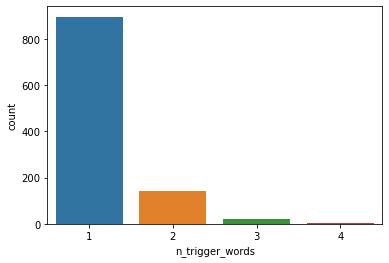

In [15]:
sns.countplot(eventdf.n_trigger_words);

## Count of each trigger word found

In [16]:
from utils import get_feature_counts_df

In [17]:
feature = 'trigger_words'
get_feature_counts_df(eventdf, feature)

,count
trigger_words,
mineralisation,684
potential,210
extensive,83
possible,75
low grade,53
broad,38
favourable,28
further drilling,19
encouraging,16


In [18]:
feature = 'ORE_DEPOSIT'
get_feature_counts_df(eventdf, feature)

,count
ORE_DEPOSIT,
base metal,152
uranium,148
lode,147
pge,145
gold deposits,125
lodes,86
gold deposit,60
cid,57
base metals,53


In [19]:
feature = 'STRAT'
get_feature_counts_df(eventdf, feature)

,count
STRAT,
greenstone belt,193
koongie park formation,56
buttons formation,50
greenstone belts,41
gascoyne complex,27
...,...
nickol river formation,1
black flag group,1
bangemall group,1


In [20]:
feature = 'TIMESCALE'
get_feature_counts_df(eventdf, feature)

,count
TIMESCALE,
archaean,128
proterozoic,87
tertiary,36
devonian,27
quaternary,14
permian,14
cambrian,12
archean,11
mesozoic,10


In [21]:
feature = 'LOCATION'
get_feature_counts_df(eventdf, feature)

,count
LOCATION,
western australia,276
australia,179
montague,178
forrestania,167
goldfields,105
...,...
mount isa mines,1
pinjin,1
fraser,1


# Ent Test

In [25]:
example = nlp(eventdf.iloc[0]['event_text'])
display_ent(example)

In [26]:
for ent in example.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

pty ltd 16 23 ORG
september 2008 25 39 DATE
sgc 70 73 ORG
gswa 113 117 PERSON
calcrete 144 152 ROCK
uranium 160 167 ORE_DEPOSIT
the dry season of 2009 346 368 DATE
the department of industry and resources 454 494 ORG
1986 520 524 DATE
nabberu basin 561 574 LOCATION
western australia 575 592 LOCATION
west australian 594 609 NORP
131 637 640 CARDINAL
130p 641 645 PRODUCT
western australia 667 684 LOCATION
western australia 758 775 LOCATION
granite 791 798 ROCK
about 150km 823 834 QUANTITY
wiluna 844 850 LOCATION
paleoproterozoic 880 896 TIMESCALE
cainozoic 976 985 TIMESCALE
sediments 986 995 ROCK
silts 996 1001 ROCK
sands 1002 1007 ROCK
calcrete 1012 1020 ROCK
siurafce 1222 1230 ORG
rab aircore 1305 1316 ORG
3 1327 1328 CARDINAL


In [27]:
minerals = [ent.text for ent in example.ents if ent.label_ == 'MINERAL']
minerals

[]